# Imports

In [1]:
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
import os
import pandas as pd
import torch

from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize

from answer_extraction import NER_Extractor
from controller import Controller
from distraction_generation import DistractionFinder
from qa_evaluation import QA_Evaluator
from question_generation.question_gen_en import QuestionGenerator
from sklearn.metrics import f1_score
from translation import Translator

[nltk_data] Downloading package punkt to C:\Users\Will
[nltk_data]     Blanton\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
e:\VS_Projects\Q-A-5525\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Constants

In [2]:
ENGLISH_JSON = "data/xquad.en.json"
SPANISH_JSON = "data/xquad.es.json"

In [3]:
TRANSLATION_FILE = "data/qa_results_translation.json"
NO_TRANSLATION_FILE = "data/qa_results_no_translation.json"

# Helper Functions

In [4]:
def load_qa_data(json_file):
    
    articles = pd.read_json(json_file)

    # turn the json into a list of dictionaries
    articles = [a for a in articles["data"]]

    return articles

In [5]:
def bleu_comparison(original: str, translated: str):
    """
    Compare the generated questions with the dataset questions using BLEU score
    """

    original_tokens = word_tokenize(original.lower())

    translated_tokens = word_tokenize(translated.lower())

    bleu_score = sentence_bleu([original_tokens], translated_tokens)

    bleu_score = bleu_score if bleu_score >= .0001 else 0

    return bleu_score

In [6]:
def compute_f1(true_answer, predicted_answer):
    # Tokenize the answers
    true_tokens = true_answer.lower().split()
    predicted_tokens = predicted_answer.lower().split()
    
    # Create sets for easier comparison
    true_set = set(true_tokens)
    predicted_set = set(predicted_tokens)
    
    # Create binary arrays
    true_labels = [1 if token in true_set else 0 for token in true_tokens + predicted_tokens]
    predicted_labels = [1 if token in predicted_set else 0 for token in true_tokens + predicted_tokens]
    
    # Calculate F1 score
    f1 = f1_score(true_labels, predicted_labels)
    return f1

In [15]:
def score_qa_pair(controller: Controller, 
                  english: dict, 
                  spanish: dict, 
                  display: bool = False,
                  translate: bool = True):
    """
    Iterate over the articles and paragraphs in the English and Spanish data to translate,
    the Spansih data is translated to English and then generate questions and answers in English.
    Evaluate 
    """

    results = []

    evaluator = QA_Evaluator()

    # iterate through the articles and paragraphs
    for i, article in enumerate(english):
        for j, paragraph in enumerate(article["paragraphs"]):
            if display and j >= 1:
                break

            # get the text to translate
            spanish_context = spanish[i]["paragraphs"][j]["context"]

            # get the correct translation
            target_context = paragraph["context"]


            # skip if the context is too large
            try:
                if translate:
                    translated_context, qa_pairs = controller.gen_qa_pairs(spanish_context)
                else:
                    translated_context, qa_pairs = controller.gen_qa_pairs(target_context,
                                                                        translate=False)
                

                # bleu_score = bleu_comparison(target_context, translated_context)

                if display:
                    print("--------------------------------------------------\n")
                    print(f"Spanish Context: {spanish_context}\n")
                    print(f"English Context: {target_context}\n")
                    print(f"Translated Context: {translated_context}\n")
                    #print(f"BLEU Score: {bleu_score}\n")
                    print("--------------------------------------------------\n")

                # target_qa = []
                # for qas in paragraph["qas"]:
                #     target_question = qas["question"]
                #     target_answer = qas["answers"][0]["text"]
                    
                #     target_qa.append((target_question, target_answer))

                for gen_q, extr_a, extr_dist in qa_pairs:

                    gen_a, sim_score = evaluator.evaluate_qa_pair(translated_context, gen_q, extr_a)

                    results.append({
                        "article_index": i,
                        # "spanish_context": spanish_context,
                        # "target_context": target_context,
                        "translated_context": translated_context,
                        #"bleu_score": bleu_score,
                        "generated_question": gen_q,
                        "extracted_answer": extr_a,
                        "QA_answer": gen_a,
                        "QA_similarity_score": sim_score,
                        "QA_F1": compute_f1(extr_a, gen_a),
                        #"distractions": extr_dist
                    })

                    if display:
                        print("--------------------------------------------------\n")
                        print(f"Generated-Q: {gen_q}\n")
                        print(f"Extracted-A: {extr_a}\n")
                        #print(f"Distractions: {extr_dist}\n")
                        # print(f"Target-QA: {target_qa}\n")
                        print("--------------------------------------------------\n")
            
            except IndexError as e:
                print(f"An index error occurred: {str(e)}")

    results_df = pd.DataFrame(results)
    results_df.set_index(["article_index", 
                          "translated_context",
                          "generated_question"], inplace=True)
    return results_df

In [8]:
def evaluate_system(controller, english, spanish, save_path, translate=True):

    if os.path.exists(save_path):
        qa_results = pd.read_json(save_path, orient='index')
        qa_results.index = pd.MultiIndex.from_tuples(qa_results.index.map(eval))
        qa_results.index.names = ["article_index", "translated_context", "generated_question"]
    else:
        qa_results = score_qa_pair(controller, 
                                   english, 
                                   spanish, 
                                   display=False,
                                   translate=translate)

        # remove duplicates
        qa_results = qa_results[~qa_results.index.duplicated(keep=False)]

        # save results to json
        qa_results.to_json(save_path, orient='index', indent=4)

    return qa_results

# Initialize Models

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

controller = Controller(
    translator=Translator(device=device),
    extractor=NER_Extractor(),
    question_generator=QuestionGenerator(),
    distraction_finder=DistractionFinder()
)

e:\VS_Projects\Q-A-5525\venv\Lib\site-packages\transformers\models\marian\tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
The `xla_device` argument has been dep

# Load in Data

In [10]:
english_qa = load_qa_data(ENGLISH_JSON)
spanish_qa = load_qa_data(SPANISH_JSON)

In [11]:
len(english_qa), len(spanish_qa)

(48, 48)

# Evaluate Language-Learning QA-Pair System

In [16]:
qa_results = evaluate_system(controller, 
                             english_qa, 
                             spanish_qa, 
                             TRANSLATION_FILE, 
                             translate=True)

qa_results.head(3)

An index error occurred: index out of range in self
An index error occurred: index out of range in self
An index error occurred: index out of range in self


extracted_answer  \
article_index translated_context                                 generated_question                                                    
0             The Panthers, who in addition to leading the NF... Who led the Panthers in passers?                            Kuechly   
                                                                 How many incumbent supporters have been selecte...            three   
              The Broncos beat the Pittsburgh Steelers in the... Who beat the Pittsburgh Steelers in the divisio...          Broncos   

                                                                                                                       QA_answer  \
article_index translated_context                                 generated_question                                                
0             The Panthers, who in addition to leading the NF... Who led the Panthers in passers?                        Kuechly   
                                                                 How many incumbent supporters have been selecte...        three   
              The Broncos beat the Pittsburgh Steelers in the... Who beat the Pittsburgh Steelers in the divisio...  The Broncos   

                                                                                                                     QA_similarity_score  \
article_index translated_context                                 generated_question                                                        
0             The Panthers, who in addition to leading the NF... Who led the Panthers in passers?                                 1.0000   
                                                                 How many incumbent supporters have been selecte...               1.0000   
              The Broncos beat the Pittsburgh Steelers in the... Who beat the Pittsburgh Steelers in the divisio...               0.9511   

                                                                                                                     QA_F1  
article_index translated_context                                 generated_question                                         
0             The Panthers, who in addition to leading the NF... Who led the Panthers in passers?                      1.0  
                                                                 How many incumbent supporters have been selecte...    1.0  
              The Broncos beat the Pittsburgh Steelers in the... Who beat the Pittsburgh Steelers in the divisio...    0.8

In [17]:
qa_results.describe()

,QA_similarity_score,QA_F1
count,764.000000,764.000000
mean,0.826955,0.722862
std,0.259432,0.393134
min,0.018658,0.000000
25%,0.712589,0.571429
50%,1.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


<Axes: title={'center': 'QA Similarity Score Distribution (Translation)'}, ylabel='Frequency'>

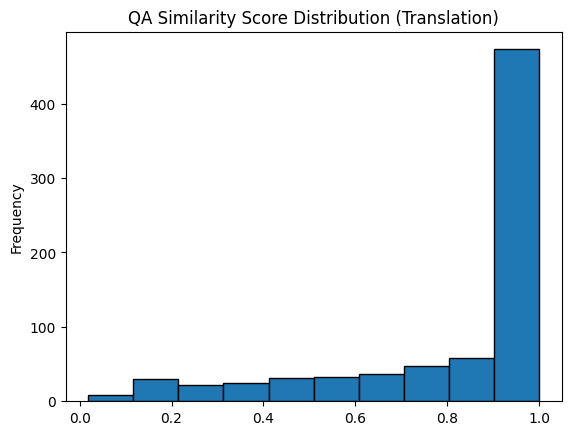

In [21]:
qa_results["QA_similarity_score"].plot.hist(edgecolor='black', 
                                     title="QA Similarity Score Distribution (Translation)")

<Axes: title={'center': 'QA F1 Score Distribution (Translation)'}, ylabel='Frequency'>

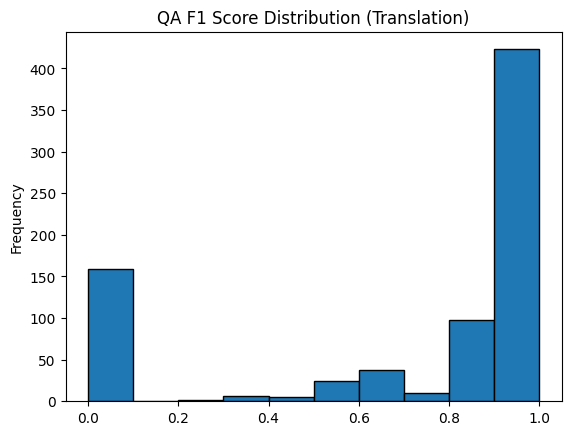

In [22]:
qa_results["QA_F1"].plot.hist(edgecolor='black',
                                title="QA F1 Score Distribution (Translation)")

# Evaluate Without Translation

In [18]:
wo_translation = evaluate_system(controller, 
                             english_qa, 
                             spanish_qa, 
                             NO_TRANSLATION_FILE, 
                             translate=False)

wo_translation.head(3)

Token indices sequence length is longer than the specified maximum sequence length for this model (661 > 512). Running this sequence through the model will result in indexing errors


extracted_answer  \
article_index translated_context                                 generated_question                                                    
0             The Panthers defense gave up just 308 points, r... How many of the Panthers' three starting lineba...              two   
                                                                 Who led the Panthers in sacks with 11?                 Kawann Short   
              The Broncos defeated the Pittsburgh Steelers in... How many playoff games did the Broncos lose?                    two   

                                                                                                                        QA_answer  \
article_index translated_context                                 generated_question                                                 
0             The Panthers defense gave up just 308 points, r... How many of the Panthers' three starting lineba...           Two   
                                                                 Who led the Panthers in sacks with 11?              Kawann Short   
              The Broncos defeated the Pittsburgh Steelers in... How many playoff games did the Broncos lose?                 two   

                                                                                                                     QA_similarity_score  \
article_index translated_context                                 generated_question                                                        
0             The Panthers defense gave up just 308 points, r... How many of the Panthers' three starting lineba...                  1.0   
                                                                 Who led the Panthers in sacks with 11?                              1.0   
              The Broncos defeated the Pittsburgh Steelers in... How many playoff games did the Broncos lose?                        1.0   

                                                                                                                     QA_F1  
article_index translated_context                                 generated_question                                         
0             The Panthers defense gave up just 308 points, r... How many of the Panthers' three starting lineba...    1.0  
                                                                 Who led the Panthers in sacks with 11?                1.0  
              The Broncos defeated the Pittsburgh Steelers in... How many playoff games did the Broncos lose?          1.0

In [19]:
wo_translation.describe()

,QA_similarity_score,QA_F1
count,801.000000,801.000000
mean,0.812440,0.705860
std,0.270848,0.400450
min,0.036753,0.000000
25%,0.682343,0.533333
50%,1.000000,0.941176
75%,1.000000,1.000000
max,1.000000,1.000000


<Axes: title={'center': 'QA Similarity Score Distribution (No Translation)'}, ylabel='Frequency'>

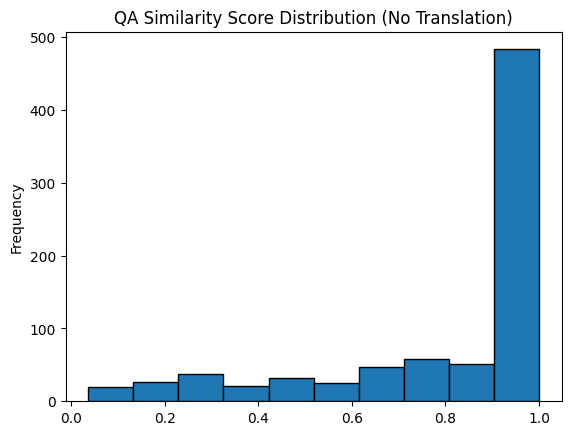

In [23]:
wo_translation["QA_similarity_score"].plot.hist(edgecolor='black',
                                        title="QA Similarity Score Distribution (No Translation)")

<Axes: title={'center': 'QA F1 Score Distribution (No Translation)'}, ylabel='Frequency'>

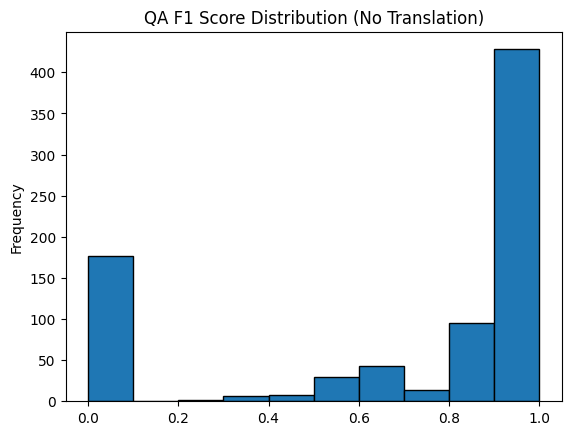

In [24]:
wo_translation["QA_F1"].plot.hist(edgecolor='black',
                                title="QA F1 Score Distribution (No Translation)")